In [1]:
import pathlib
import numpy as np 
import re
import seaborn as sns 
from matplotlib import pyplot as plt 
import pandas as pd 

In [2]:
def read_beam_file(path, beam_size=100):
    # turns out output is interleaved? 
    with open(path) as f1:
        lines = [x.strip().split(" ") for x in f1.readlines()]

    outputs = {i: [] for i in range(len(lines)//beam_size)}
    for i in range(len(lines)):
        orig_idx = i % (len(lines) // beam_size) 
        outputs[orig_idx].append(lines[i])

    for idx, l in outputs.items():
        try:
            assert(len(l) == beam_size)
        except AssertionError:
            print(len(l))
            print(idx)
            raise AssertionError()
    return outputs 

def read_input_file(path): 
    with open(path) as f1:
        return [x.strip().split(" ") for x in f1.readlines()]

def get_data_prob(train_path, fxn_of_interest, trigger_tokens, starts=False, equals=False):
    with open(train_path.joinpath("train.src_tok")) as src_f, open(train_path.joinpath("train.tgt")) as tgt_f:
        src_lines = [x.strip().split(" ") for x in src_f.readlines()]
        tgt_lines = [x.strip().split(" ") for x in tgt_f.readlines()]

    # remove context  
    for i, line in enumerate(src_lines):
        user_idxs = [j for j, tok in enumerate(line) if tok == "__User"]
        line = line[user_idxs[-1]+1:]
        src_lines[i] = line

    count_output_has_fxn = 0
    count_input_has_trigger = 0
    count_output_has_fxn_and_input_has_trigger= 0
    for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)):
        has_trigger = False
        has_fxn = False 
        for tok in trigger_tokens:
            if not starts and not equals:
                if tok in [x.lower() for x in src_l]:
                    has_trigger = True
                    break
            elif equals and not starts:
                if " ".join(tok).lower() == " ".join(src_l).lower():
                    has_trigger = True
                    break
            else:
                if src_l[0].lower() == tok: 
                    has_trigger = True
                    break
        if fxn_of_interest in tgt_l:
            has_fxn = True
        if has_trigger:
            count_input_has_trigger += 1
        if has_trigger and has_fxn:
            count_output_has_fxn += 1
        if has_trigger and has_fxn:
            count_output_has_fxn_and_input_has_trigger += 1

        if not has_fxn and has_trigger:
            print(" ".join(src_l))
            print(" ".join(tgt_l))


    prob_fxn_given_trigger = count_output_has_fxn_and_input_has_trigger / (count_input_has_trigger)
    prob_trigger_given_fxn = count_output_has_fxn_and_input_has_trigger / (count_output_has_fxn)

    return prob_fxn_given_trigger, prob_trigger_given_fxn

def get_beam_prob(inputs, beam_predictions, fxn_of_interest):
    beam_probs = []

    for i, inp, plan in inputs: 
        all_preds = beam_predictions[i]
        # print(" ".join(inp))
        # print(" ".join(all_preds[0]))
        split_preds = [re.split("[ \(\)]", " ".join(p)) for p in all_preds]
        all_has_fxn = [1 if fxn_of_interest in pred else 0 for pred in split_preds]
        num_fxn_of_interest = sum(all_has_fxn)
        total = len(all_preds) 
        beam_probs.append(num_fxn_of_interest/total)

    return beam_probs

def get_inputs_of_interest(path, fxn_of_interest): 
    src_path = path.joinpath("fxn_test_valid.src_tok")
    tgt_path = path.joinpath("fxn_test_valid.tgt")

    src_lines = read_input_file(src_path)
    tgt_lines = read_input_file(tgt_path)

    pairs_of_interest = [(i, src_l, tgt_l) for i, (src_l, tgt_l) in enumerate(zip(src_lines, tgt_lines)) if fxn_of_interest in tgt_l]

    return pairs_of_interest


def main(path, pred_path, fxn_of_interest, trigger_tokens, beam_size=100, starts = False):
    p_fxn_given_trigger, __ = get_data_prob(path, fxn_of_interest, trigger_tokens, starts=starts)
    pairs_of_interest = get_inputs_of_interest(path, fxn_of_interest)

    beam_preds = read_beam_file(pred_path, beam_size) 
    # print("\n".join([" ".join(x) for x in beam_preds[0][0:3]]))
    # print("\n".join([" ".join(x) for x in beam_preds[0][-3:]]))
    beam_probs = get_beam_prob(pairs_of_interest, beam_preds, fxn_of_interest) 

    return (p_fxn_given_trigger, np.mean(beam_probs))



In [3]:


data_to_plot = {str(k): {"data_prob": [], "beam_prob": []} for k in [5000, 10000, 20000, 50000, 100000, "max"]}

findmanager_df = pd.DataFrame(columns=["num_train", "seed", "prob", "type"], dtype=object)



for split in ["5000", "10000", "20000", "50000", "100000", "max"]:
    for seed in [12, 31, 64]:
        data_path = pathlib.Path(f"/home/t-eliass/resources/data/smcalflow_samples_curated/FindManager/{split}_100")
        pred_path = pathlib.Path(f"/home/t-eliass/amlt_models/transformer/FindManager_{seed}_seed/{split}_100/translate_output/fxn_test_valid_top_100.tgt")
        triggers = ["supervisor", "boss", "manager", "skip", "bossman"]
        data_prob, beam_prob_estimate = main(data_path, pred_path, "FindManager", triggers, 100)

        data_to_plot[str(split)]["data_prob"].append(data_prob)
        data_to_plot[str(split)]["beam_prob"].append(beam_prob_estimate)


        to_append_beam = {"seed": seed, "num_train": split, "prob": beam_prob_estimate, "type": "beam"}
        to_append_data = {"seed": seed, "num_train": split, "prob": data_prob, "type": "data"}
        findmanager_df = findmanager_df.append(to_append_beam, ignore_index=True)
        findmanager_df = findmanager_df.append(to_append_data, ignore_index=True)

        print(f"split {split} seed {seed}")
        print(f"{data_prob:.2f}")
        print(f"{beam_prob_estimate:.2f}")




Create weekly reminder for meeting with boss . __StartOfProgram
( FenceRecurring )
change the manager meeting to 1 pm __StartOfProgram
( Yield ( UpdateCommitEventWrapper ( UpdatePreflightEventWrapper ( Event.id ( singleton ( QueryEventResponse.results ( FindEventWrapperWithDefaults ( Event.subject_? ( ?~= " manager meeting " ) ) ) ) ) ) ( Event.start_? ( DateTime.time_? ( ?= ( NumberPM 1L ) ) ) ) ) ) )
An hour before that manager meeting , I need planning time where I 'm showing as busy on the calendar . __StartOfProgram
( Yield ( CreateCommitEventWrapper ( CreatePreflightEventWrapper ( & ( & ( Event.subject_? ( ?= " planning time " ) ) ( Event.start_? ( ?= ( PeriodDurationBeforeDateTime ( Event.start ( Execute ( refer ( extensionConstraint ( ^ ( Event ) EmptyStructConstraint ) ) ) ) ) ( PeriodDuration.apply :duration ( toHours 1 ) ) ) ) ) ) ( Event.showAs_? ( ?= ( ShowAsStatus.Busy ) ) ) ) ) ) )
Create an event with the name of " boss 's surprise party " next month . __StartOfProgram


KeyboardInterrupt: 

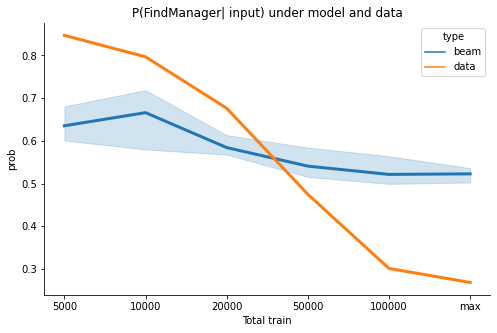

In [25]:


fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=findmanager_df, x="num_train", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(FindManager| input) under model and data")
ax.set_xlabel("Total train")

plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/FindManager_prob_beam_data.pdf")


In [30]:
data_to_plot = {str(k): {"data_prob": [], "beam_prob": []} for k in [5000, 10000, 20000, 50000, 100000, "max"]}

tomorrow_df = pd.DataFrame(columns=["num_train", "seed", "prob", "type"], dtype=object)



for split in ["5000", "10000", "20000", "50000", "100000", "max"]:
    for seed in [12, 31, 64]:
        data_path = pathlib.Path(f"/home/t-eliass/resources/data/smcalflow_samples_curated/Tomorrow/{split}_100")
        pred_path = pathlib.Path(f"/home/t-eliass/amlt_models/transformer/Tomorrow_{seed}_seed/{split}_100/translate_output/fxn_test_valid_top_100.tgt")
        triggers = ["tomorrow", "tomorow", "tommorow", "tommorrow", "tomorow"]
        data_prob, beam_prob_estimate = main(data_path, pred_path, "Tomorrow", triggers, 100)

        data_to_plot[str(split)]["data_prob"].append(data_prob)
        data_to_plot[str(split)]["beam_prob"].append(beam_prob_estimate)


        to_append_beam = {"seed": seed, "num_train": split, "prob": beam_prob_estimate, "type": "beam"}
        to_append_data = {"seed": seed, "num_train": split, "prob": data_prob, "type": "data"}
        tomorrow_df = tomorrow_df.append(to_append_beam, ignore_index=True)
        tomorrow_df = tomorrow_df.append(to_append_data, ignore_index=True)

        print(f"split {split} seed {seed}")
        print(f"{data_prob:.2f}")
        print(f"{beam_prob_estimate:.2f}")

Add lunch with mom tomorrow at 1 pm . __StartOfProgram
( FenceAttendee )
Remind me of tomorrow 's events at 5 am __StartOfProgram
( FenceReminder )
is it going to be the same at the golf league tomorrow night ? __StartOfProgram
( Yield ( Execute ( NewClobber ( refer ( ^ ( Dynamic ) ActionIntensionConstraint ) ) ( ^ ( ( Constraint Point ) ) roleConstraint ( Path.apply " place " ) ) ( intension ( AtPlace ( FindPlace ( LocationKeyphrase.apply " golf league " ) ) ) ) ) ) )
Please schedule a meeting with the pope tomorrow . __StartOfProgram
( FenceAttendee )
Can you cancel all events tomorrow ? __StartOfProgram
( FenceMultiAction )
What else is scheduled for tomorrow ? __StartOfProgram
( Yield ( Execute ( refer ( cursorNext ( extensionConstraint ( ^ ( Event ) EmptyStructConstraint ) ) ) ) ) )
Can you cancel all events for tomorrow __StartOfProgram
( FenceMultiAction )
Remind me to book the tickets for the movies tomorrow __StartOfProgram
( FenceReminder )
Add dinner with family tomorrow fro

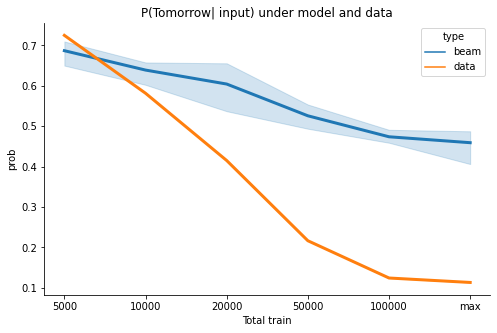

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=tomorrow_df, x="num_train", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(Tomorrow| input) under model and data")
ax.set_xlabel("Total train")

plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/Tomorrow_prob_beam_data.pdf")

In [29]:
seed = 12
split = "max"
data_path = pathlib.Path(f"/home/t-eliass/resources/data/smcalflow_samples_curated/Tomorrow/{split}_100")
pred_path = pathlib.Path(f"/home/t-eliass/amlt_models/transformer/Tomorrow_{seed}_seed/{split}_100/translate_output/fxn_test_valid_top_100.tgt")
triggers = ["tomorrow"]
data_prob, beam_prob_estimate = main(data_path, pred_path, "Tomorrow", triggers, 100)



# print(f"split {split} seed {seed}")
# print(f"{data_prob:.2f}")
# print(f"{beam_prob_estimate:.2f}")



Thanks , can you also cancel all my appointments for tomorrow ? __StartOfProgram
( FenceMultiAction )
What do I have for tomorrow and Monday ? __StartOfProgram
( FenceDateTime )
set lunch with friend tomorrow at 2 pm __StartOfProgram
( FenceAttendee )
Block out an hour this evening for exercise , look up catering options tomorrow at 3 pm and delete what I have on Wednesday next week . __StartOfProgram
( FenceMultiAction )
Do I have a workout with Alicia scheduled tomorrow ? __StartOfProgram
( Yield ( > ( size ( QueryEventResponse.results ( FindEventWrapperWithDefaults ( & ( Event.subject_? ( ?= " workout " ) ) ( Event.attendees_? ( AttendeeListHasRecipientConstraint ( RecipientWithNameLike ( ^ ( Recipient ) EmptyStructConstraint ) ( PersonName.apply " Alicia " ) ) ) ) ) ) ) ) 0L ) )
Great ! Schedule lacrosse practice at 5 today , for an hour , and at 4 tomorrow for two hours . __StartOfProgram
( FenceMultiAction )
Setup lunch with mom tomorrow . __StartOfProgram
( FenceAttendee )
I 'm 

In [6]:

data_to_plot = {str(k): {"data_prob": [], "beam_prob": []} for k in [5000, 10000, 20000, 50000, 100000, "max"]}

donotconfirm_df = pd.DataFrame(columns=["num_train", "seed", "prob", "type"], dtype=object)



for split in ["5000", "10000", "20000", "50000", "100000", "max"]:
    for seed in [12, 31, 64]:
        data_path = pathlib.Path(f"/home/t-eliass/resources/data/smcalflow_samples_big/DoNotConfirm/{split}_100")
        pred_path = pathlib.Path(f"/home/t-eliass/amlt_models/transformer/DoNotConfirm_{seed}_seed/{split}_100/translate_output/fxn_test_valid_top_100.tgt")
        triggers = ["no"]
        data_prob, beam_prob_estimate = main(data_path, pred_path, "DoNotConfirm", triggers, 100, starts=True, equals=False)

        data_to_plot[str(split)]["data_prob"].append(data_prob)
        data_to_plot[str(split)]["beam_prob"].append(beam_prob_estimate)


        to_append_beam = {"seed": seed, "num_train": split, "prob": beam_prob_estimate, "type": "beam"}
        to_append_data = {"seed": seed, "num_train": split, "prob": data_prob, "type": "data"}
        donotconfirm_df = donotconfirm_df.append(to_append_beam, ignore_index=True)
        donotconfirm_df = donotconfirm_df.append(to_append_data, ignore_index=True)

        print(f"split {split} seed {seed}")
        print(f"{data_prob:.2f}")
        print(f"{beam_prob_estimate:.2f}")

No , you do n't need to include my name . __StartOfProgram
( FenceOther )
No thank you __StartOfProgram
( PleasantryAnythingElseCombined )
No , cancel that . That 's not when I want the appointment calendared . __StartOfProgram
( Yield ( DeleteCommitEventWrapper ( DeletePreflightEventWrapper ( Event.id ( Execute ( refer ( extensionConstraint ( ^ ( Event ) EmptyStructConstraint ) ) ) ) ) ) ) )
No I want you to add " Work out " to my calendar after dinner with Craig ends . __StartOfProgram
( Yield ( CreateCommitEventWrapper ( CreatePreflightEventWrapper ( & ( Event.subject_? ( ?= " Work out " ) ) ( Event.start_? ( ?= ( Event.end ( singleton ( QueryEventResponse.results ( FindEventWrapperWithDefaults ( & ( Event.subject_? ( ?~= " dinner " ) ) ( Event.attendees_? ( AttendeeListHasRecipientConstraint ( RecipientWithNameLike ( ^ ( Recipient ) EmptyStructConstraint ) ( PersonName.apply " Craig " ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
No , it should be in the morning . __StartOfProgram
( Yield ( Execut

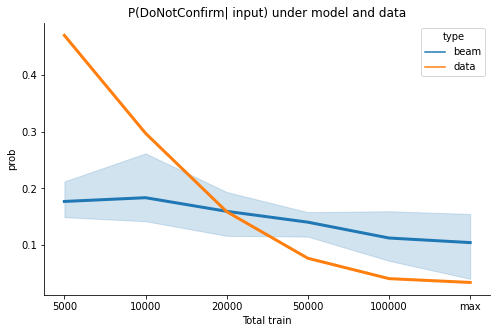

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=donotconfirm_df, x="num_train", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(DoNotConfirm| input) under model and data")
ax.set_xlabel("Total train")

plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/DoNotConfirm_prob_beam_data.pdf")

Great . Please invite all office contacts except for the Supervisor . __StartOfProgram
( FenceAttendee )
Hello Thomas , I hope you are doing well today ! I appreciate your help today , as always . I would like for you to find out what time my appointment with our PR manager is , and reach out to Samsung and attempt to book a meeting with the manager of marketing . I 'd love to get a collaboration going between us ! __StartOfProgram
( FenceMultiAction )
Please delete the sales conference with Bob and his supervisor on June 12 th at 4 PM __StartOfProgram
( let ( x0 ( PersonName.apply " Bob " ) ) ( Yield ( DeleteCommitEventWrapper ( DeletePreflightEventWrapper ( Event.id ( singleton ( QueryEventResponse.results ( FindEventWrapperWithDefaults ( EventOnDateTime ( DateAtTimeWithDefaults ( MD 12L ( June ) ) ( NumberPM 4L ) ) ( & ( Event.subject_? ( ?~= " sales conference " ) ) ( Event.attendees_? ( & ( AttendeeListHasRecipientConstraint ( RecipientWithNameLike ( ^ ( Recipient ) EmptyStructCon

Text(0.5, 0, 'Total train')

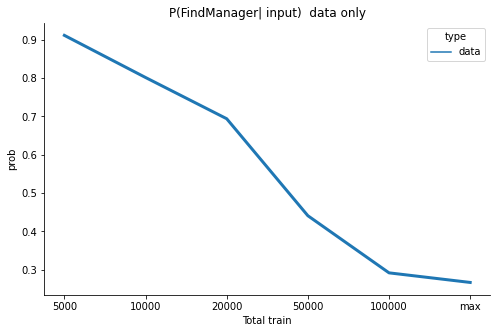

In [7]:




data_to_plot = {str(k): {"data_prob": [], "beam_prob": []} for k in [5000, 10000, 20000, 50000, 100000, "max"]}

findmanager_df = pd.DataFrame(columns=["num_train", "seed", "prob", "type"], dtype=object)



for split in ["5000", "10000", "20000", "50000", "100000", "max"]:
    # for seed in [12, 31, 64]:
    data_path = pathlib.Path(f"/srv/local1/estengel/resources/data/smcalflow_samples_no_source/FindManager/{split}_100")
    triggers = ["supervisor", "boss", "manager", "skip", "bossman"]
    p_fxn_given_trigger, p_triggers_given_fxn  = get_data_prob(data_path, "FindManager", triggers, starts=False)
    data_to_plot[str(split)]["data_prob"].append(p_fxn_given_trigger)

    to_append_data = {"seed": 12, "num_train": split, "prob": p_fxn_given_trigger, "type": "data"}

    findmanager_df = findmanager_df.append(to_append_data, ignore_index=True)

    # print(f"split {split} seed {12}")
    # print(f"{data_prob:.2f}")



fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(data=findmanager_df, x="num_train", y="prob", hue="type", linewidth=3)
sns.despine()
ax.set_title("P(FindManager| input)  data only")
ax.set_xlabel("Total train")

# plt.savefig("/home/t-eliass/papers/incremental_function_learning/figures/DoNotConfirm_prob_beam_data.pdf")

